In [69]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils import class_weight
import seaborn as sns
import gc
import copy

In [70]:
torch.cuda.set_device(0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [71]:
device

device(type='cuda')

In [72]:
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

# Create dataset

In [73]:
trainset = np.load('train.pkl', allow_pickle=True)
testset = np.load('test_no_target.pkl', allow_pickle=True)

In [74]:
X, y = [torch.from_numpy(x[0]) for x in trainset], np.array([x[1] for x in trainset], dtype=np.float64)

In [75]:
test_X = [torch.from_numpy(x) for x in testset]

<AxesSubplot:ylabel='count'>

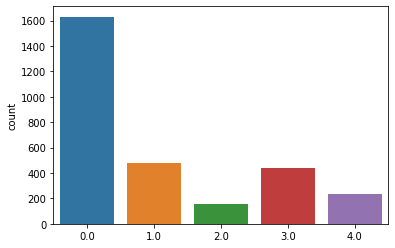

In [76]:
sns.countplot(x=y)

Dataset is imbalanced.

Calculate class weights so that they can be used in loss function.

In [77]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

## Add padding

In [78]:
# Add all zeroes sequence to train data of length 8966 - because that is the maximum sequence length in test set (then will be removed)
X.append(torch.zeros(size=(8966,), dtype=torch.float64))

In [79]:
x_padded = pad_sequence(X, batch_first=True, padding_value=0)[:-1] # Add padding to sequences
test_x_padded = pad_sequence(test_X, batch_first=True, padding_value=0)

In [80]:
x_padded = x_padded.numpy()
test_x_padded = test_x_padded.numpy()

In [81]:
x_padded.shape

(2939, 8966)

In [82]:
train_indices = np.random.rand(len(x_padded))>0.2

In [83]:
full_train_X = torch.from_numpy(x_padded).float()
full_train_y = torch.from_numpy(y).long()

train_X = torch.from_numpy(x_padded[train_indices]).float()
train_y = torch.from_numpy(y[train_indices]).long()

val_X = torch.from_numpy(x_padded[~train_indices]).float()
val_y = torch.from_numpy(y[~train_indices]).long()

In [84]:
test_X = torch.from_numpy(test_x_padded).float()

In [85]:
full_train_X.shape, train_X.shape, val_X.shape

(torch.Size([2939, 8966]), torch.Size([2328, 8966]), torch.Size([611, 8966]))

In [86]:
full_train_dataset = TensorDataset(full_train_X, full_train_y)
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)

In [87]:
full_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Train the model

### Help functions

In [88]:
def plot_training(iters, losses, train_acc, val_acc=None):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    if val_acc:
        plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')

    plt.show()

In [89]:
def get_results(model, data):
    model.eval()
    with torch.no_grad():
        hidden, state = model.init_hidden(data.shape[0])
        hidden, state = hidden.to(device), state.to(device)
        outputs, _ = model(data.to(device).unsqueeze(2), (hidden, state))
        y_pred = torch.argmax(outputs, 1).cpu().numpy()

    return outputs, y_pred

In [90]:
def get_accuracy(model, data, targets):
    model.eval()
    with torch.no_grad():
        hidden, state = model.init_hidden(data.shape[0])
        hidden, state = hidden.to(device), state.to(device)
        predictions, _ = model(data.to(device).unsqueeze(2), (hidden, state))

    return (torch.argmax(predictions, 1).cpu() == targets).sum().item() / data.shape[0]

In [91]:
def plot_cms(y_true, y_pred, dataset_type):
    cm = confusion_matrix(y_true, y_pred)
    heatmap(cm, annot=True)
    plt.title(f'{dataset_type} confusion matrix')
    plt.xlabel('prediction')
    plt.ylabel('true label')
    plt.show()

In [92]:
def show_metrics(y_true, y_pred, dataset_type):
    plot_cms(y_true, y_pred, dataset_type)

    print(f"{dataset_type} set")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted', zero_division=0):.3}")
    print(f"Recall: {recall_score(y_true, y_pred, average='weighted', zero_division=0):.3}")
    print(f"F1 score: {f1_score(y_true, y_pred, average='weighted', zero_division=0):.3}")

# Create the model

In [93]:
class LSTMClassifier(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, out_size, sequence_len, dropout, bidirectional = False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size*sequence_len*self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size)
        state = torch.zeros(self.num_layers*self.bidirectional, batch_size, self.hidden_size)
        return hidden, state

    def forward(self, x, hidden):
        x = torch.transpose(x, 0, 1)
        all_outputs, hidden = self.lstm(x, hidden)
        all_outputs = torch.transpose(all_outputs, 0, 1)
        out = torch.flatten(all_outputs, 1)
        x = self.fc1(out)
        return x, hidden

# Training and tuning hyperparameters

In [94]:
INPUT_SIZE = 1
HIDDEN_SIZE = 7
NUM_LAYERS = 2
OUTPUT_SIZE = 5
SEQUENCE_LEN = x_padded.shape[1]
EPOCHS = 50
LR = 0.0005
DROPOUT_LSTM = 0.7

In [95]:
model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, SEQUENCE_LEN, DROPOUT_LSTM).to(device)
model

LSTMClassifier(
  (lstm): LSTM(1, 7, num_layers=2, dropout=0.7)
  (fc1): Linear(in_features=62762, out_features=5, bias=True)
)

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [97]:
iters = []
losses = []
train_acc_ls = []
val_acc_ls = []
best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0

for epoch in range(EPOCHS):
    epoch_losses = []
    for x, targets in train_loader:
        model.train()
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        predictions, _ = model(x, (hidden, state))
        predictions = predictions.squeeze(1)

        optimizer.zero_grad()
        loss = criterion(predictions, targets)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # clear variables
        del x, targets, predictions
        gc.collect()
        torch.cuda.empty_cache()

    model.eval()

    loss_mean = np.array(epoch_losses).mean()
    iters.append(epoch)
    losses.append(loss_mean)
    train_acc = get_accuracy(model, train_X, train_y)
    val_acc = get_accuracy(model, val_X, val_y)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(val_acc)
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f"[{epoch+1}/{EPOCHS}] loss: {loss_mean:.3f} train_acc: {train_acc*100:.2f}% val_acc: {val_acc*100:.2f}%")

print('Training finished')
model.load_state_dict(best_model_wts)
print("Best training accuracy: {:.2f}".format(max(train_acc_ls)))
print("Best validation accuracy: {:.2f}".format(max(val_acc_ls)))

[1/50] loss: 1.439 train_acc: 59.92% val_acc: 59.74%
[2/50] loss: 1.206 train_acc: 57.60% val_acc: 56.46%
[3/50] loss: 1.222 train_acc: 58.29% val_acc: 58.76%
[4/50] loss: 1.107 train_acc: 63.02% val_acc: 62.52%
[5/50] loss: 1.072 train_acc: 62.63% val_acc: 63.01%
[6/50] loss: 1.054 train_acc: 63.92% val_acc: 63.01%
[7/50] loss: 1.021 train_acc: 65.46% val_acc: 64.81%
[8/50] loss: 1.010 train_acc: 63.83% val_acc: 64.32%
[9/50] loss: 0.985 train_acc: 66.11% val_acc: 65.79%
[10/50] loss: 0.952 train_acc: 65.64% val_acc: 64.98%
[11/50] loss: 0.952 train_acc: 67.70% val_acc: 67.27%
[12/50] loss: 0.930 train_acc: 67.91% val_acc: 66.28%
[13/50] loss: 0.896 train_acc: 68.17% val_acc: 66.45%
[14/50] loss: 0.880 train_acc: 67.96% val_acc: 65.96%
[15/50] loss: 0.876 train_acc: 69.20% val_acc: 67.27%
[16/50] loss: 0.849 train_acc: 70.40% val_acc: 68.58%
[17/50] loss: 0.847 train_acc: 70.83% val_acc: 70.05%
[18/50] loss: 0.823 train_acc: 71.43% val_acc: 69.07%
[19/50] loss: 0.806 train_acc: 71.78%

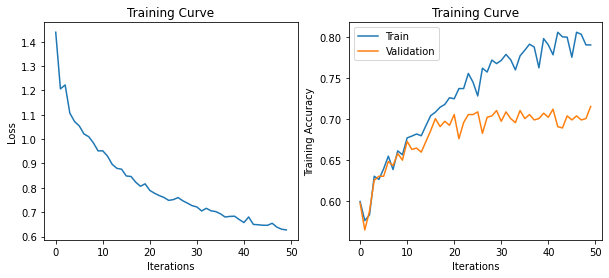

In [98]:
plot_training(iters, losses, train_acc_ls, val_acc_ls)

# Evaluate the best model

In [99]:
outputs_train, y_pred_train = get_results(model, train_X)
outputs_val, y_pred_val = get_results(model, val_X)

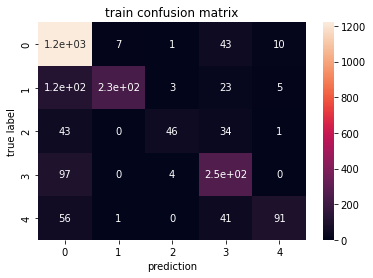

train set
Accuracy: 0.79
Precision: 0.807
Recall: 0.79
F1 score: 0.779


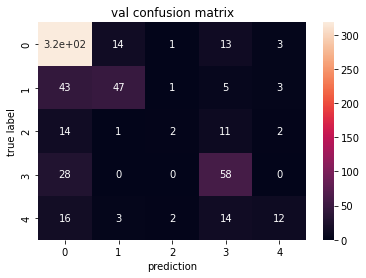

val set
Accuracy: 0.715
Precision: 0.694
Recall: 0.715
F1 score: 0.686


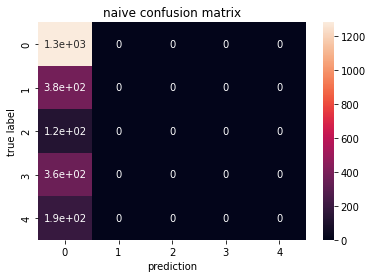

naive set
Accuracy: 0.55
Precision: 0.303
Recall: 0.55
F1 score: 0.391


(None, None, None)

In [100]:
show_metrics(train_y, y_pred_train, "train"), show_metrics(val_y, y_pred_val, "val"), show_metrics(train_y, np.zeros_like(train_y), "naive")

c:\users\bartosz\dataspellprojects\pytorch-neural-networks\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

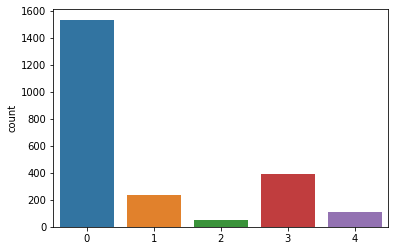

In [101]:
sns.countplot(y_pred_train)

c:\users\bartosz\dataspellprojects\pytorch-neural-networks\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

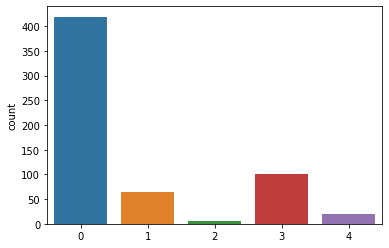

In [102]:
sns.countplot(y_pred_val)

In [103]:
outputs_full_train, y_pred_full_train = get_results(model, full_train_X)

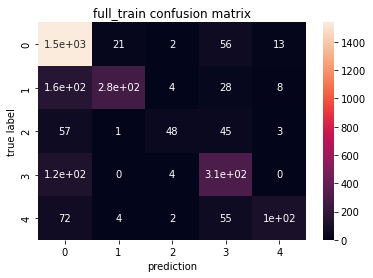

full_train set
Accuracy: 0.775
Precision: 0.787
Recall: 0.775
F1 score: 0.76


In [104]:
show_metrics(full_train_y, y_pred_full_train, "full_train")

# Save final predictions

In [105]:
_, final_predictions = get_results(model, test_X)

c:\users\bartosz\dataspellprojects\pytorch-neural-networks\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

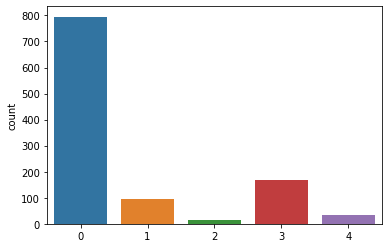

In [106]:
sns.countplot(final_predictions)

In [107]:
with open('final_predictions.csv', 'w') as fh:
    for i in final_predictions:
        fh.write(f'{i.item()}\n')